# Liver Cancer Classification with PyTorch (Andrew A. Borkowski, MD)

## Part 1: Creating the ML Model

In [1]:
# Imports here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import time

In [2]:
# Specify Data Directories

data_dir = 'data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [9]:
# Check for cuda

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [4]:
# Define transforms for the training, validation, and testing sets

training_transforms = transforms.Compose([transforms.RandomRotation(60),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

In [5]:
# Load the datasets with ImageFolder

training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

In [6]:
# Using the image datasets and the trainforms, define the dataloaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=150, shuffle=False)

In [7]:
# Buid your model with trasfer learning

model = models.resnet152(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
# Freeze pretrained model parameters and create a new classifier

for parameter in model.parameters():
    parameter.requires_grad = False

from collections import OrderedDict

# Build custom classifier

classifier = nn.Sequential(OrderedDict([('fc', nn.Linear(2048, 3)),
                                        ('output', nn.LogSoftmax(dim=1))]))
model.fc = classifier

In [10]:
# Function for the validation pass

def validation(model, validateloader, loss_func):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validateloader):

        images, labels = images.to(device), labels.to(device)

        output = model.forward(images)
        val_loss += loss_func(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

In [11]:
# Loss function and optimizer

loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000810, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, 
            threshold=0.01, cooldown=0, min_lr=.00001, verbose=True)

In [12]:
# Train the classifier

num_epochs = 30
def train_classifier():
    valid_loss_min = np.inf

    model.to(device)

    for epoch in range(num_epochs):

        running_loss = 0
        start = time.time()
        model.train()

        for images, labels in iter(train_loader):
            model.train()


            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            output = model.forward(images)
            loss = loss_func(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            
# Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            validation_loss, accuracy = validation(model, validate_loader, loss_func)
            
        scheduler.step(validation_loss)

        print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Validation Loss: {:.3f}.. ".format(validation_loss/len(validate_loader)),
              "Validation Accuracy: {:.3f}".format(accuracy/len(validate_loader)),
              "Time per epoch: {:.3f}".format(time.time()-start))
    
        # save model if validation loss has decreased
        if validation_loss/len(validate_loader) <= valid_loss_min/len(validate_loader):
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
            valid_loss_min/len(validate_loader),
            validation_loss/len(validate_loader)))
            torch.save(model.state_dict(), 'model_resnet152.pth')
            valid_loss_min = validation_loss

        running_loss = 0
                    
train_classifier()

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1/30..  Training Loss: 0.940..  Validation Loss: 0.743..  Validation Accuracy: 0.749 Time per epoch: 21.692
Validation loss decreased (inf --> 0.743085). Saving model ...
Epoch: 2/30..  Training Loss: 0.624..  Validation Loss: 0.604..  Validation Accuracy: 0.759 Time per epoch: 19.486
Validation loss decreased (0.743085 --> 0.603640). Saving model ...
Epoch: 3/30..  Training Loss: 0.520..  Validation Loss: 0.512..  Validation Accuracy: 0.811 Time per epoch: 19.588
Validation loss decreased (0.603640 --> 0.511589). Saving model ...
Epoch: 4/30..  Training Loss: 0.508..  Validation Loss: 0.452..  Validation Accuracy: 0.866 Time per epoch: 19.913
Validation loss decreased (0.511589 --> 0.452364). Saving model ...
Epoch: 5/30..  Training Loss: 0.556..  Validation Loss: 0.455..  Validation Accuracy: 0.851 Time per epoch: 19.187
Epoch: 6/30..  Training Loss: 0.460..  Validation Loss: 0.624..  Validation Accuracy: 0.713 Time per epoch: 19.957
Epoch: 7/30..  Training Loss: 0.416..  Vali

In [13]:
# Train the whole model

model.load_state_dict(torch.load('model_resnet152.pth'))

for parameter in model.parameters():
    parameter.requires_grad = True
    
optimizer = optim.Adam(model.parameters(), lr=0.000081, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, 
            threshold=0.01, cooldown=0, min_lr=.00001, verbose=True)    
    
num_epochs = 3

def train_classifier():

    model.to(device)

    for epoch in range(num_epochs):

        running_loss = 0
        start = time.time()

        for images, labels in iter(train_loader):
            model.train()

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            output = model.forward(images)
            loss = loss_func(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
             

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            validation_loss, accuracy = validation(model, validate_loader, loss_func)
            
        scheduler.step(validation_loss)

        print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Validation Loss: {:.3f}.. ".format(validation_loss/len(validate_loader)),
              "Validation Accuracy: {:.3f}".format(accuracy/len(validate_loader)),
              "Time per epoch: {:.3f}".format(time.time()-start))

        running_loss = 0
                    
train_classifier()

Epoch: 1/3..  Training Loss: 0.350..  Validation Loss: 0.170..  Validation Accuracy: 0.951 Time per epoch: 21.451
Epoch: 2/3..  Training Loss: 0.187..  Validation Loss: 0.216..  Validation Accuracy: 0.908 Time per epoch: 21.264
Epoch: 3/3..  Training Loss: 0.161..  Validation Loss: 0.100..  Validation Accuracy: 0.947 Time per epoch: 21.739


## Part 2: Evaluating the model on unseen (test) data

In [14]:
# Evaluate the model on test set

def test_accuracy(model, test_loader):

    model.eval()
    model.to(device)

    with torch.no_grad():
    
        accuracy = 0
    
        for images, labels in iter(test_loader):
            images, labels = images.to(device), labels.to(device)
            output = model.forward(images)
            probabilities = torch.exp(output)
            equality = (labels.data == probabilities.max(dim=1)[1])
            accuracy += equality.type(torch.FloatTensor).mean()
        
        print("Test Accuracy: {}".format(accuracy/len(test_loader)))    
        
        
test_accuracy(model, test_loader)

Test Accuracy: 0.9599999785423279


In [23]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

# Confusion matrix
cm=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(cm)


[[46  3  1]
 [ 0 49  1]
 [ 0  1 49]]


In [24]:
# Create list of classes

classes = testing_dataset.class_to_idx
classes_list = list(classes.keys())
classes_list

['CholangioCA', 'HepatocellularCA', 'MixedCA']

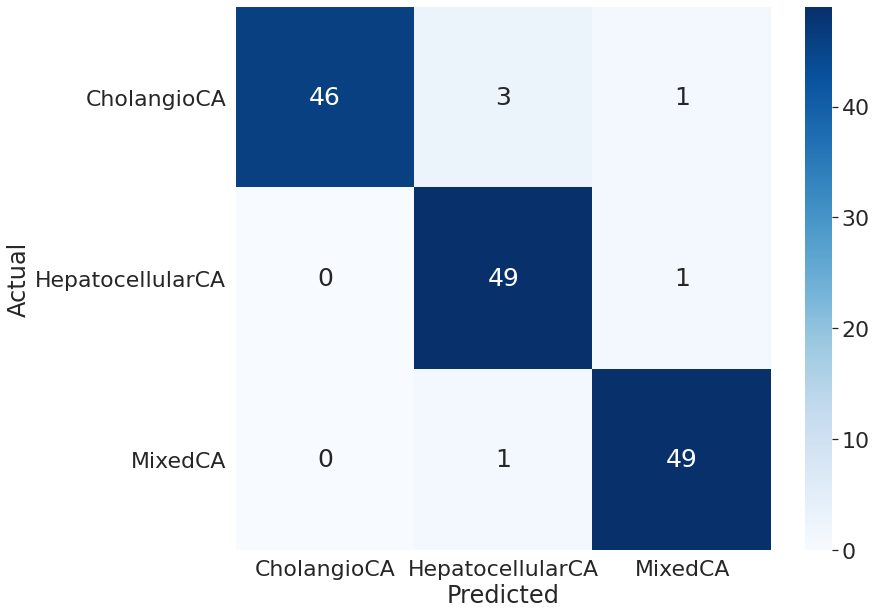

In [25]:
#Plot confution matrix

def plot_cm(cm, index, columns):
    df_cm = pd.DataFrame(cm, index, columns)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (12,10))
    sns.set(font_scale=2.0)
    sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 25})
    
plot_cm(cm, index=classes_list, columns=classes_list)

In [31]:
# Calculate metrics for the liver cholagiocarcinoma
tp = cm[0][0]
fn = cm[0][1] + cm[0][2]
fp = cm[1][0] + cm[2][0]
tn = 100 - fp

sensitivity = tp/(tp + fn)
specificity = tn/(fp + tn)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
print(f'For the liver cholangiocarcinom our model showed: \n\
{sensitivity:.2f} sensitivity \n\
{specificity:.2f} specificity \n\
{ppv:.2f} positive predictive value \n\
{npv:.2f} negative predictive value')

For the liver cholangiocarcinom our model showed: 
0.92 sensitivity 
1.00 specificity 
1.00 positive predictive value 
0.96 negative predictive value


In [32]:
# Calculater metrics for the liver hepatocellular carcinoma
tp2 = cm[1][1]
fn2 = cm[1][0] + cm[1][2]
fp2 = cm[0][1] + cm[2][1]
tn2 = 100 - fp2

sensitivity2 = tp2/(tp2 + fn2)
specificity2 = tn2/(fp2 + tn2)
ppv2 = tp2/(tp2+fp2)
npv2 = tn2/(tn2+fn2)
print(f'For the liver hepatocellular carcinoma our model showed: \n\
{sensitivity2:.2f} sensitivity \n\
{specificity2:.2f} specificity \n\
{ppv2:.2f} positive predictive value \n\
{npv2:.2f} negative predictive value')

For the liver hepatocellular carcinoma our model showed: 
0.98 sensitivity 
0.96 specificity 
0.92 positive predictive value 
0.99 negative predictive value


In [33]:
# Calculate metrics for the mixed liver cholongiocarcinoma and hepatocellular ca
tp3 = cm[2][2]
fn3 = cm[2][0] + cm[2][1]
fp3 = cm[0][2] + cm[1][2]
tn3 = 100 - fp3

sensitivity3 = tp3/(tp3 + fn3)
specificity3 = tn3/(fp3 + tn3)
ppv3 = tp3/(tp3+fp3)
npv3 = tn3/(tn3+fn3)
print(f'For the liver mixed carcinoma our model showed: \n\
{sensitivity3:.2f} sensitivity \n\
{specificity3:.2f} specificity \n\
{ppv3:.2f} positive predictive value \n\
{npv3:.2f} negative predictive value')

For the liver mixed carcinoma our model showed: 
0.98 sensitivity 
0.98 specificity 
0.96 positive predictive value 
0.99 negative predictive value


## Part 3: Inference

In [26]:
# Process a PIL image for use in a PyTorch model 
# Scales, crops, and normalizes a PIL image for a PyTorch model
# Returns image as Numpy array

from PIL import Image

def process_image(image_path):
      
    pil_image = Image.open(image_path)
    
    # Resize
    
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((256, 256))
    else:
        pil_image.thumbnail((256, 256))
        
    # Crop 
    
    left_margin = (pil_image.width-224)/2
    bottom_margin = (pil_image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # Normalize
    
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # PyTorch expects the color channel to be the first dimension, 
    # but it's the third dimension in the PIL image and Numpy array
    # Color channel needs to be first; retain the order of the other two dimensions.
    
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

In [27]:
image_path = 'data/test/CholangioCA/cholangio201.jpg'
#image_path = 'data/test/HepatocellularCA/hcc201.jpg'
#image_path = 'data/test/MixedCA/mixed201.jpg'

In [28]:
# Show Image

def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    if title is not None:
        ax.set_title(title)
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image = process_image(image_path)
#imshow(image)

In [29]:
# Predict the class from an image file

model.class_to_idx = training_dataset.class_to_idx

def predict(image_path, model, topk=3):
    
    image = process_image(image_path)
    
    # Convert image to PyTorch tensor first
    
    image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    #print(image.shape)
    #print(type(image))
    
    # Return a new tensor with a dimension of size one inserted at the specified position.
    
    image = image.unsqueeze(0)
    output = model.forward(image)
    probabilities = torch.exp(output)
    
    # Probabilities and the indices of those probabilities corresponding to the classes
    
    top_probabilities, top_indices = probabilities.topk(topk)
    
    # Convert to lists
    
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    
    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.
    
    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    #print(idx_to_class)
    
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes  
      

    
probs, classes = predict(image_path, model)   
#print(probs)
#print(classes)
print('Liver cancer type is {},'.format(classes[0]))
print('with probability of {}'.format(round(probs[0], 2)))
print('\n')
print('Liver cancer type is {},'.format(classes[1]))
print('with probability of {}'.format(round(probs[1], 2)))
print('\n')
print('Liver cancer type is {},'.format(classes[2]))
print('with probability of {}'.format(round(probs[2], 2)))

Liver cancer type is CholangioCA,
with probability of 0.84


Liver cancer type is HepatocellularCA,
with probability of 0.16


Liver cancer type is MixedCA,
with probability of 0.0


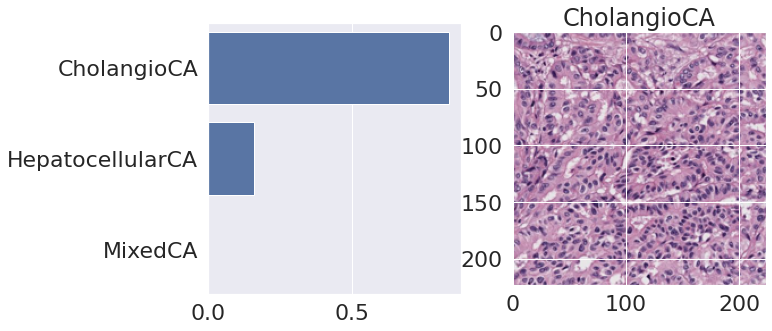

In [30]:
# Display an image along with all classes' probabilities

plt.figure(figsize = (10,5))

# Plot the probabilities for all the classes as a bar graph
plt.subplot(1,2,1)

sns.barplot(x=probs, y=classes, color=sns.color_palette()[0]);

# Plot cancer input image

p1 = plt.subplot(1,2,2)

image = process_image(image_path)

cancer_title = classes[0]

imshow(image, p1, title=cancer_title);

plt.show()